In [19]:
# ========== IMPORTS ==========

In [20]:
import os

In [21]:
import random

In [22]:
import torch

In [23]:
import torch.nn as nn

In [24]:
import torch.optim as optim

In [25]:
from torch.utils.data import Dataset, DataLoader

In [26]:
from torchvision import transforms, utils

In [27]:
from PIL import Image

In [28]:
import matplotlib.pyplot as plt

In [29]:
from tqdm import tqdm

In [30]:
import numpy as np

In [31]:
from pytorch_fid import fid_score

In [32]:
# ========== SETUP ==========

In [33]:
dataset_path = "/kaggle/input/horse2zebra-dataset"

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [35]:
img_size = 256

In [36]:
print(f"Using device: {device}")
print(f"Dataset path: {dataset_path}")
print("Folder contents:")
print(os.listdir(dataset_path))

Using device: cuda
Dataset path: /kaggle/input/horse2zebra-dataset
Folder contents:
['testB', 'testA', 'trainB', 'trainA', 'metadata.csv']


In [37]:
# ========== TRANSFORMS ==========

In [38]:
transform_train = transforms.Compose([
    transforms.Resize(int(img_size * 1.12)),
    transforms.RandomCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [39]:
transform_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [40]:
# ========== DATASET CLASS ==========

In [41]:
class CycleGANDataset(Dataset):
    def __init__(self, root_dir, mode="train", transform=None):
        self.transform = transform
        self.dir_A = os.path.join(root_dir, f"{mode}A")
        self.dir_B = os.path.join(root_dir, f"{mode}B")
        self.images_A = sorted(os.listdir(self.dir_A))
        self.images_B = sorted(os.listdir(self.dir_B))
        self.len_A = len(self.images_A)
        self.len_B = len(self.images_B)
        self.length = max(self.len_A, self.len_B)

        print(f"\n[{mode.upper()} SET]")
        print(f"Path A: {self.dir_A} ({self.len_A} images)")
        print(f"Path B: {self.dir_B} ({self.len_B} images)")

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        img_A_path = os.path.join(self.dir_A, self.images_A[idx % self.len_A])
        img_B_path = os.path.join(self.dir_B, self.images_B[random.randint(0, self.len_B - 1)])

        img_A = Image.open(img_A_path).convert("RGB")
        img_B = Image.open(img_B_path).convert("RGB")

        if self.transform:
            img_A = self.transform(img_A)
            img_B = self.transform(img_B)

        return {"A": img_A, "B": img_B}


In [42]:
# ========== LOAD DATA ==========

In [43]:
train_dataset = CycleGANDataset(dataset_path, "train", transform_train)


[TRAIN SET]
Path A: /kaggle/input/horse2zebra-dataset/trainA (1067 images)
Path B: /kaggle/input/horse2zebra-dataset/trainB (1334 images)


In [44]:
test_dataset = CycleGANDataset(dataset_path, "test", transform_test)


[TEST SET]
Path A: /kaggle/input/horse2zebra-dataset/testA (120 images)
Path B: /kaggle/input/horse2zebra-dataset/testB (140 images)


In [45]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [46]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [47]:
# ========== DISPLAY SAMPLE IMAGES ==========

In [77]:
def show_sample_images(dataset, num_samples=10):
    for i in range(num_samples):
        sample = dataset[i]
        img_A = sample["A"] * 0.5 + 0.5  # denormalize
        img_B = sample["B"] * 0.5 + 0.5

        plt.figure(figsize=(6,3))
        plt.subplot(1, 2, 1)
        plt.imshow(np.transpose(img_A.numpy(), (1, 2, 0)))
        plt.title(f"Sample {i+1} - A")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(np.transpose(img_B.numpy(), (1, 2, 0)))
        plt.title(f"Sample {i+1} - B")
        plt.axis("off")

        plt.show()


Showing sample images from training dataset...


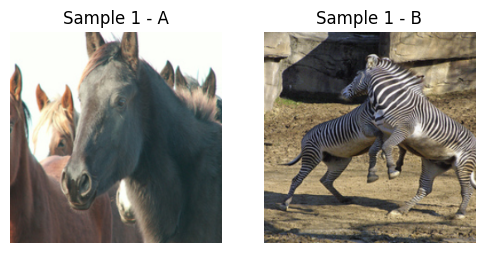

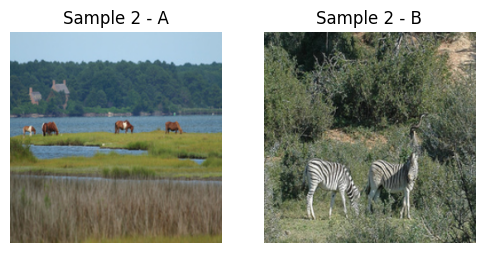

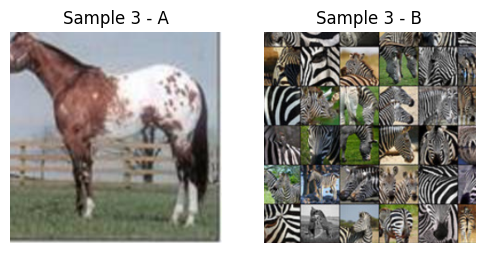

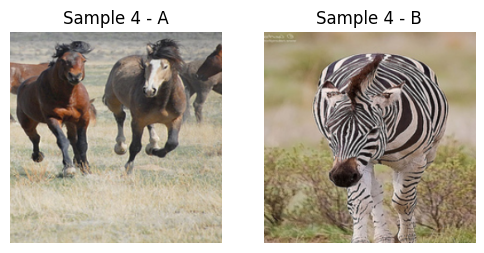

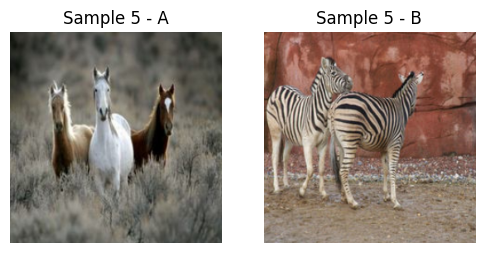

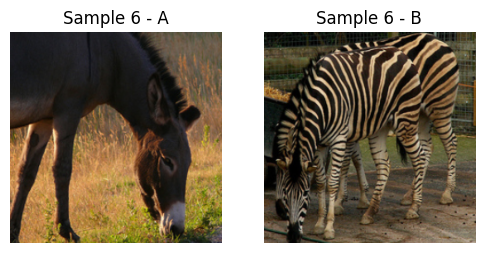

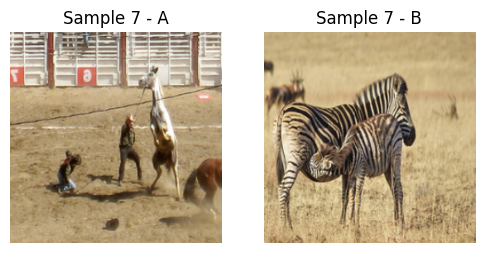

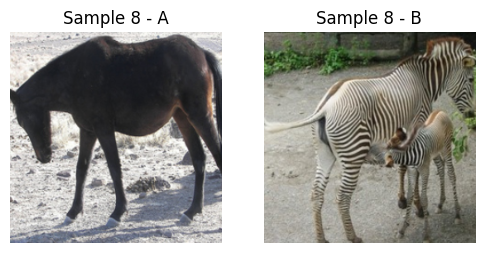

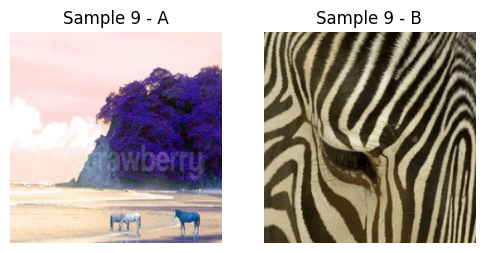

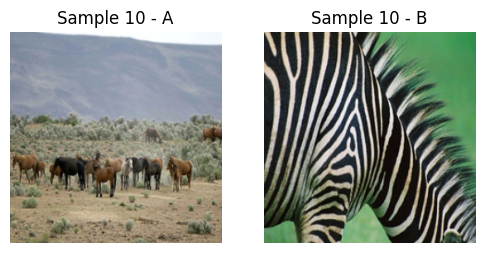

In [78]:
print("\nShowing sample images from training dataset...")
show_sample_images(train_dataset, num_samples=10)

In [50]:
# ======== MODEL DEFINITIONS ========

In [51]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, 3, bias=False),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, 3, bias=False),
            nn.InstanceNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)

In [52]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, num_residual_blocks=9):
        super().__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels, 64, 7, bias=False),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1, bias=False),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2

        for _ in range(num_residual_blocks):
            model += [ResidualBlock(in_features)]

        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1, bias=False),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2

        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, out_channels, 7),
            nn.Tanh()
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [53]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        def block(in_filters, out_filters, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        self.model = nn.Sequential(
            *block(in_channels, 64, normalize=False),
            *block(64, 128),
            *block(128, 256),
            *block(256, 512),
            nn.ZeroPad2d((1,0,1,0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, x):
        return self.model(x)

In [54]:
# ========== INIT MODELS ==========

In [55]:
G_AB = Generator().to(device)

In [56]:
G_BA = Generator().to(device)

In [57]:
D_A = Discriminator().to(device)

In [58]:
D_B = Discriminator().to(device)

In [59]:
# ========== LOSSES AND OPTIMIZERS ==========

In [60]:
criterion_GAN = nn.MSELoss()

In [61]:
criterion_cycle = nn.L1Loss()

In [62]:
criterion_identity = nn.L1Loss()

In [63]:
optimizer_G = optim.Adam(list(G_AB.parameters()) + list(G_BA.parameters()), lr=0.0002, betas=(0.5, 0.999))

In [64]:
optimizer_D_A = optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [65]:
optimizer_D_B = optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [66]:
# ========== TRAINING FUNCTION ==========

In [67]:
def train_cyclegan(n_epochs=1):
    for epoch in range(n_epochs):
        print(f"\n=== Epoch {epoch+1}/{n_epochs} ===")
        for i, batch in enumerate(tqdm(train_loader)):
            real_A = batch["A"].to(device)
            real_B = batch["B"].to(device)

            # Train Generators
            optimizer_G.zero_grad()
            loss_id_A = criterion_identity(G_BA(real_A), real_A)
            loss_id_B = criterion_identity(G_AB(real_B), real_B)

            fake_B = G_AB(real_A)
            fake_A = G_BA(real_B)
            loss_GAN_AB = criterion_GAN(D_B(fake_B), torch.ones_like(D_B(fake_B)))
            loss_GAN_BA = criterion_GAN(D_A(fake_A), torch.ones_like(D_A(fake_A)))

            rec_A = G_BA(fake_B)
            rec_B = G_AB(fake_A)
            loss_cycle_A = criterion_cycle(rec_A, real_A)
            loss_cycle_B = criterion_cycle(rec_B, real_B)

            loss_G = (loss_GAN_AB + loss_GAN_BA +
                      10.0 * (loss_cycle_A + loss_cycle_B) +
                      5.0 * (loss_id_A + loss_id_B))
            loss_G.backward()
            optimizer_G.step()

            # Train Discriminator A
            optimizer_D_A.zero_grad()
            loss_D_A_real = criterion_GAN(D_A(real_A), torch.ones_like(D_A(real_A)))
            loss_D_A_fake = criterion_GAN(D_A(fake_A.detach()), torch.zeros_like(D_A(fake_A)))
            loss_D_A = (loss_D_A_real + loss_D_A_fake) * 0.5
            loss_D_A.backward()
            optimizer_D_A.step()

            # Train Discriminator B
            optimizer_D_B.zero_grad()
            loss_D_B_real = criterion_GAN(D_B(real_B), torch.ones_like(D_B(real_B)))
            loss_D_B_fake = criterion_GAN(D_B(fake_B.detach()), torch.zeros_like(D_B(fake_B)))
            loss_D_B = (loss_D_B_real + loss_D_B_fake) * 0.5
            loss_D_B.backward()
            optimizer_D_B.step()

            if i % 100 == 0:
                print(f"[Batch {i}/{len(train_loader)}] "
                      f"Loss G: {loss_G.item():.4f}, "
                      f"Loss D_A: {loss_D_A.item():.4f}, "
                      f"Loss D_B: {loss_D_B.item():.4f}")

In [68]:
# ========== START TRAINING ==========

In [69]:
train_cyclegan(n_epochs=1)


=== Epoch 1/1 ===


  0%|          | 1/1334 [00:00<15:15,  1.46it/s]

[Batch 0/1334] Loss G: 18.8002, Loss D_A: 0.4981, Loss D_B: 0.8488


  8%|▊         | 101/1334 [00:58<12:15,  1.68it/s]

[Batch 100/1334] Loss G: 7.3863, Loss D_A: 0.2546, Loss D_B: 0.3576


 15%|█▌        | 201/1334 [01:54<11:26,  1.65it/s]

[Batch 200/1334] Loss G: 10.2202, Loss D_A: 0.2312, Loss D_B: 0.1626


 23%|██▎       | 301/1334 [02:51<10:23,  1.66it/s]

[Batch 300/1334] Loss G: 7.3655, Loss D_A: 0.2516, Loss D_B: 0.2493


 30%|███       | 401/1334 [03:47<09:25,  1.65it/s]

[Batch 400/1334] Loss G: 6.5574, Loss D_A: 0.4162, Loss D_B: 0.3367


 38%|███▊      | 501/1334 [04:44<08:23,  1.66it/s]

[Batch 500/1334] Loss G: 10.1945, Loss D_A: 0.1662, Loss D_B: 0.2348


 45%|████▌     | 601/1334 [05:40<07:22,  1.66it/s]

[Batch 600/1334] Loss G: 6.3587, Loss D_A: 0.2779, Loss D_B: 0.1603


 53%|█████▎    | 701/1334 [06:37<06:22,  1.65it/s]

[Batch 700/1334] Loss G: 6.8591, Loss D_A: 0.1371, Loss D_B: 0.2478


 60%|██████    | 801/1334 [07:34<05:22,  1.65it/s]

[Batch 800/1334] Loss G: 7.6860, Loss D_A: 0.2253, Loss D_B: 0.2192


 68%|██████▊   | 901/1334 [08:30<04:21,  1.65it/s]

[Batch 900/1334] Loss G: 6.7529, Loss D_A: 0.1174, Loss D_B: 0.2215


 75%|███████▌  | 1001/1334 [09:27<03:21,  1.65it/s]

[Batch 1000/1334] Loss G: 7.5616, Loss D_A: 0.3136, Loss D_B: 0.2468


 83%|████████▎ | 1101/1334 [10:24<02:20,  1.66it/s]

[Batch 1100/1334] Loss G: 9.2645, Loss D_A: 0.2011, Loss D_B: 0.0829


 90%|█████████ | 1201/1334 [11:20<01:20,  1.65it/s]

[Batch 1200/1334] Loss G: 7.4284, Loss D_A: 0.1607, Loss D_B: 0.1938


 98%|█████████▊| 1301/1334 [12:17<00:19,  1.65it/s]

[Batch 1300/1334] Loss G: 5.8704, Loss D_A: 0.1482, Loss D_B: 0.0857


100%|██████████| 1334/1334 [12:36<00:00,  1.76it/s]


In [70]:
#  ========== SAVE & SHOW SAMPLES ==========

In [71]:
def denormalize(tensor):
    return tensor * 0.5 + 0.5

In [72]:
def save_samples(epoch):
    os.makedirs("samples", exist_ok=True)
    with torch.no_grad():
        test_batch = next(iter(test_loader))
        real_A = test_batch["A"].to(device)
        real_B = test_batch["B"].to(device)

        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)
        rec_A = G_BA(fake_B)
        rec_B = G_AB(fake_A)

        grid = torch.cat([
            denormalize(real_A.cpu()),
            denormalize(fake_B.cpu()),
            denormalize(rec_A.cpu()),
            denormalize(real_B.cpu()),
            denormalize(fake_A.cpu()),
            denormalize(rec_B.cpu())
        ], 0)

        sample_path = f"samples/cyclegan_{epoch}.png"
        utils.save_image(grid, sample_path, nrow=3, normalize=False)
        print(f"\nSaved sample image to {sample_path}")
        plt.imshow(np.transpose(grid[0].numpy(), (1,2,0)))
        plt.title("Real A")
        plt.axis("off")
        plt.show()

In [73]:
# =========save each real-fake pair as separate image files while also showing them on screen=========

In [74]:
def show_and_save_generated_images(G, data_loader, device, num_images=10, save_dir="generated_pairs"):
    G.eval()
    images_shown = 0

    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    with torch.no_grad():
        plt.figure(figsize=(8, num_images * 3))

        for batch in data_loader:
            real = batch["A"].to(device)
            fake = G(real)

            real_img = real.cpu() * 0.5 + 0.5
            fake_img = fake.cpu() * 0.5 + 0.5

            batch_size = real_img.size(0)
            for i in range(batch_size):
                if images_shown >= num_images:
                    break

                # Show real image
                plt.subplot(num_images, 2, images_shown * 2 + 1)
                plt.imshow(np.transpose(real_img[i].numpy(), (1, 2, 0)))
                plt.title("Real", fontsize=14)
                plt.axis("off")

                # Show fake image
                plt.subplot(num_images, 2, images_shown * 2 + 2)
                plt.imshow(np.transpose(fake_img[i].numpy(), (1, 2, 0)))
                plt.title("Fake", fontsize=14)
                plt.axis("off")

                # Save pair side-by-side
                fig, axs = plt.subplots(1, 2, figsize=(8, 4))
                axs[0].imshow(np.transpose(real_img[i].numpy(), (1, 2, 0)))
                axs[0].set_title("Real")
                axs[0].axis("off")
                axs[1].imshow(np.transpose(fake_img[i].numpy(), (1, 2, 0)))
                axs[1].set_title("Fake")
                axs[1].axis("off")
                fig.tight_layout(pad=3.0)
                fig.savefig(f"{save_dir}/pair_{images_shown+1}.png")
                plt.close(fig)

                images_shown += 1

            if images_shown >= num_images:
                break

        plt.tight_layout(pad=3.0)
        plt.show()

In [75]:
# Call the function to display and save 20 image pairs

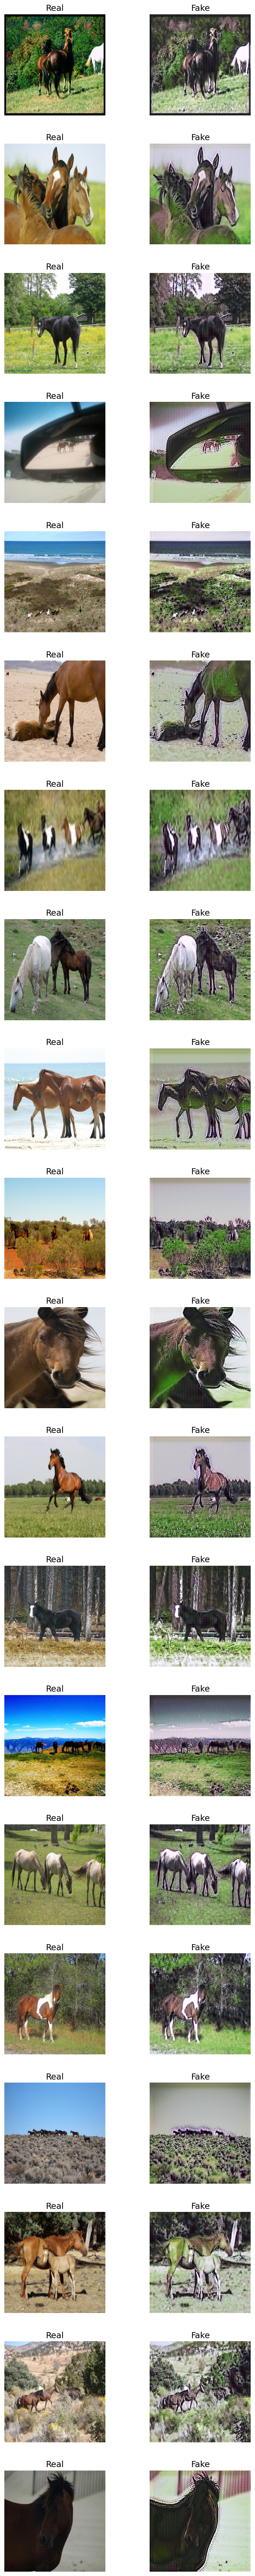

In [76]:
show_and_save_generated_images(G_AB, test_loader, device, num_images=20)